# 🏗️Import Necessary Libraries

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The code imports various data science libraries, including TensorFlow and scikit-learn, and defines a neural network model using the EfficientNet architecture. It also includes system libraries for handling file paths and metrics for evaluating model performance. Additionally, it sets up various callbacks and optimizers to optimize the training process.</p>

In [190]:
#!pip install tensorflow
#!pip install opencv-python
#!pip install cv2
# !pip install BIRDS
# pip install --upgrade --user pip
# !pip install google.colab

In [191]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path

# import birds_utils.BIRDS
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path
import random

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns
import birds_utils as birds
sns.set_style('darkgrid')

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Principle parameters

In [192]:
# principle parameters
BATCH_SIZE = 32 # size of batch (The ImageDataGenerator objects generate batches of tensor image data with real-time data augmentation)
TARGET_SIZE = (224, 224)    # size of pictures (used by the ImageDataGenerator objects)
N_LABELS = 2    # number of lables for analysis ('all will keep all labels)
N_EPOCHS = 1 # number of epochs for the traning NN
N_SAMPLES_PER_LABEL = 'all' # number of sampels per label that are kept for training ('all' will keep all samples)

# 🤙Create helper functions

In [193]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# # Import series of helper functions for our notebook
# from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [194]:
# import urllib.request

# url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"
# filename = "helper_functions.py"
# urllib.request.urlretrieve(url, filename)

# 📥Load and Transform Data

In [195]:
project_dir = '.'
test_df_full = birds.load_data(project_dir).drop_duplicates()  



In [196]:
def filter_df(df,labels=None,N_samples_per_label=None):
  if isinstance(labels, str):
    labels = [labels]

  df_filt = pd.DataFrame()
  if (labels != None):        
    df_filt = df[df['label'].isin(labels)]

  elif (N_samples_per_label !=None):
    labels = birds.get_labels(df)
    for label in labels:
      df_tmp = filter_df(df,labels=list([label]))
      # print(df_filt)
      df_tmp = df_tmp.iloc[0:min(N_samples_per_label,df_tmp.shape[0])]
      df_filt = pd.concat([df_filt,df_tmp])
    
  return df_filt


In [197]:
if (N_LABELS=='all'):
    N_LABELS = len(birds.get_labels(test_df_full))
    
lables = list(birds.get_labels(test_df_full)[0:N_LABELS])
test_df = birds.filter_df(test_df_full,labels=lables)
test_df = birds.filter_df(test_df,N_samples_per_label=N_SAMPLES_PER_LABEL)


# 🔭Visualizing images from the dataset

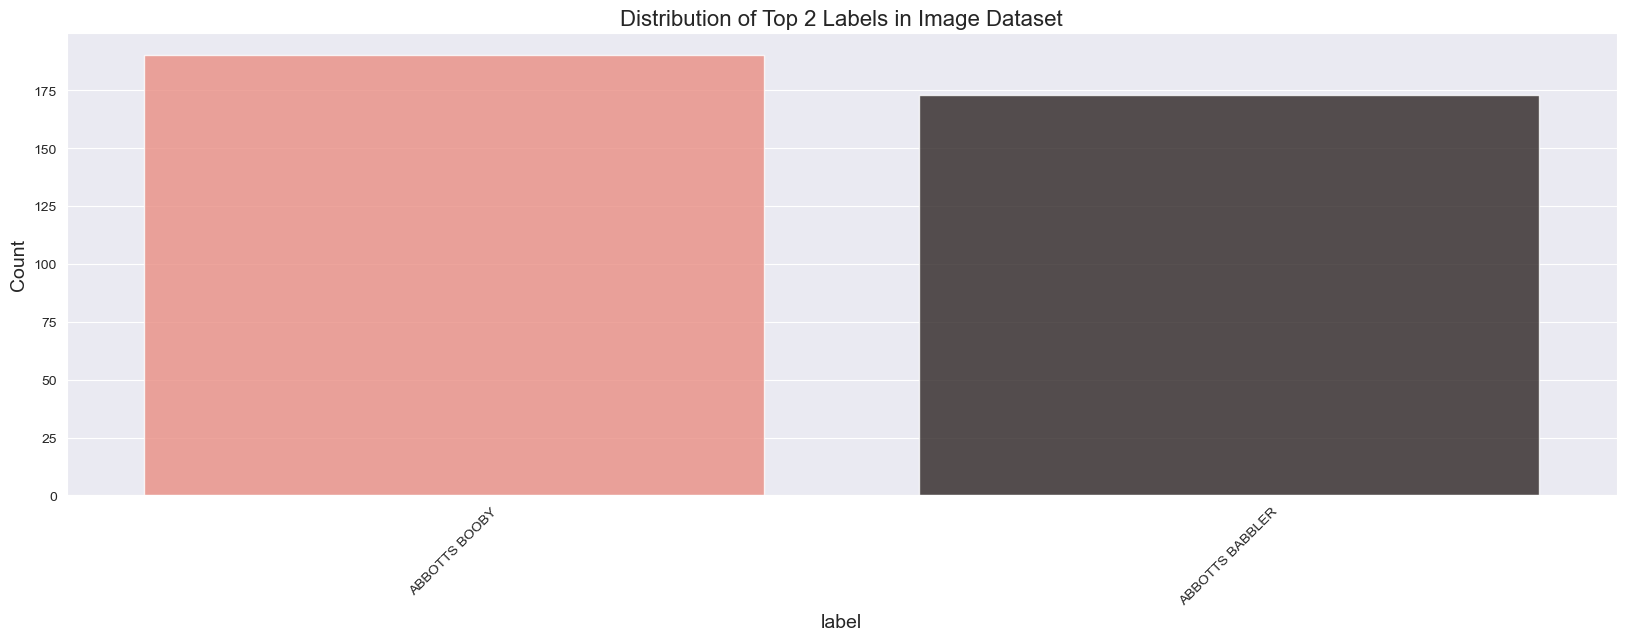

In [198]:
# birds.test_df
# plot all images of a label
# # plot the 1'st 5 instances of a labelbirds.plot_label_images(test_df,label=birds.get_labels(test_df)[1])

# birds.plot_label_images(test_df,label=birds.get_labels(test_df)[1],N=5)

# # plot tests according to idx
# birds.plot_label_tests(test_df,idx=[1,9])

birds.plot_labels_count(test_df)

# Data Splitting into 3 ImageDataGenerators


In [199]:
# Separate in train and test data

# we saw that the df was balanced so we added stratify=test_df['label']
train_df, test_df = train_test_split(test_df, test_size=0.2, shuffle=True, random_state=42,stratify=test_df['label'])


In [200]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [201]:

# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 232 validated image filenames belonging to 2 classes.
Found 58 validated image filenames belonging to 2 classes.
Found 73 validated image filenames belonging to 2 classes.


# Image Augemntation

## Define the image augmentation object

In [202]:
# Data Augmentation Step
RANDOM_FLIP = 'horizontal'
RANDOM_ROTATION = 0.1
RANDOM_ZOOM = 0.9
RANDOM_CONTRAST = 0.1

augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
#   layers.experimental.preprocessing.Rescaling(1./255),
#   layers.experimental.preprocessing.RandomFlip(RANDOM_FLIP),
#   layers.experimental.preprocessing.RandomRotation(RANDOM_ROTATION),
  layers.experimental.preprocessing.RandomZoom(RANDOM_ZOOM),
#   layers.experimental.preprocessing.RandomContrast(RANDOM_CONTRAST),
])

## 🚄Observing augemented images

In [203]:
augment = tf.keras.Sequential([
  # layers.experimental.preprocessing.Resizing(224,224),
#   layers.experimental.preprocessing.Rescaling(1./255),
#   layers.experimental.preprocessing.RandomFlip(RANDOM_FLIP),
#   layers.experimental.preprocessing.RandomRotation(RANDOM_ROTATION),
  layers.experimental.preprocessing.RandomZoom(0.1,1),
#   layers.experimental.preprocessing.RandomContrast(RANDOM_CONTRAST),
])

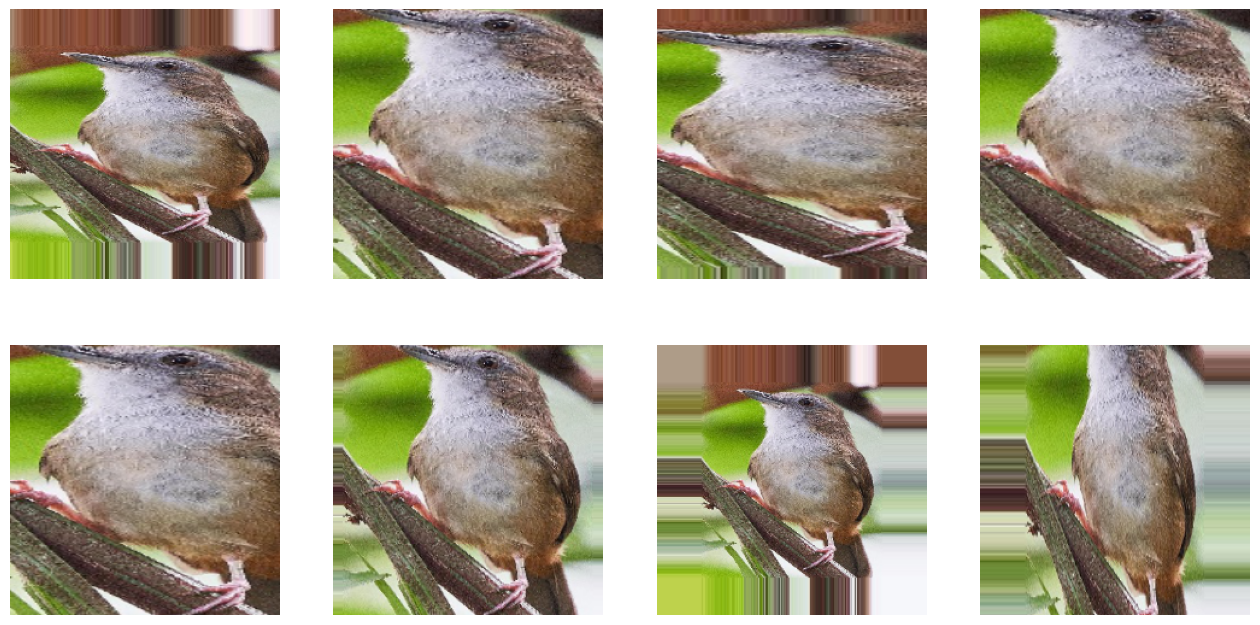

In [204]:
# Define a custom data generator with zoom range for width and height
def custom_data_generator(img, batch_size=8, zoom_level=(0.5)):
    datagen = ImageDataGenerator(
        zoom_range=(1 - zoom_level, 1 + zoom_level),
        fill_mode='nearest'
    )

    # img_array = img.img_to_array(img)
    img_array = np.expand_dims(img, axis=0)

    generator = datagen.flow(img_array, batch_size=batch_size)

    return generator

# Assuming you have the image already loaded
img = birds.get_image(test_df,idx=1)

# Create a generator
generator = custom_data_generator(img)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(2):
    for j in range(4):
        augmented_images = generator.next()
        augmented_image = augmented_images[0].astype('uint8')

        axes[i, j].imshow(augmented_image)
        axes[i, j].axis('off')

plt.show()


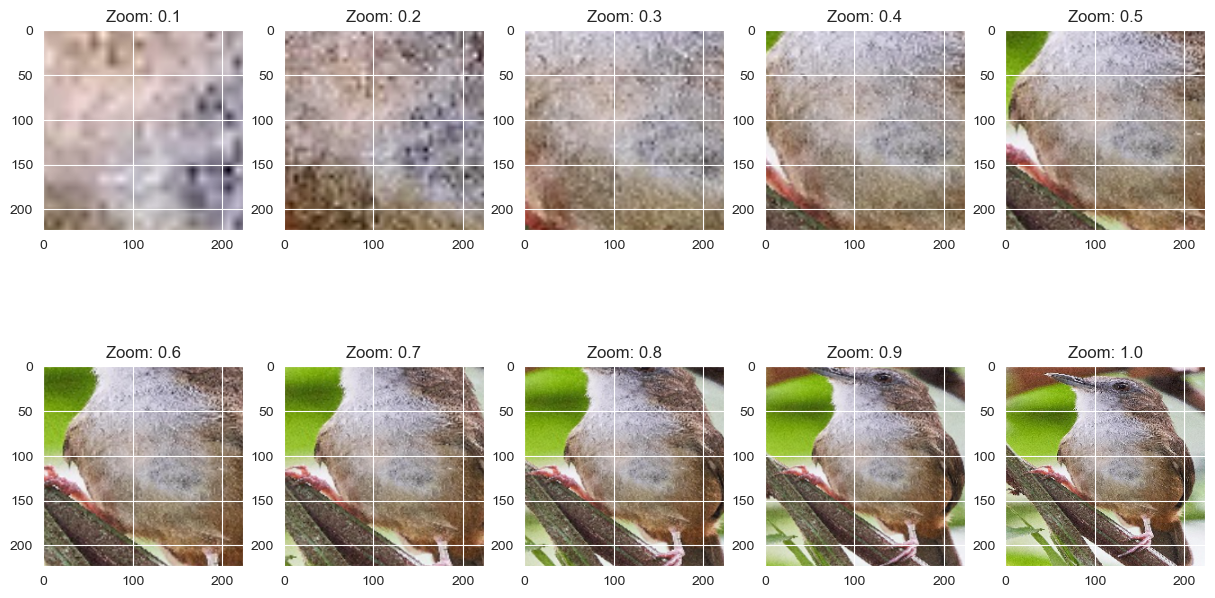

In [205]:
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import matplotlib.pyplot as plt
# import numpy as np

# # Create an ImageDataGenerator with zoom range
datagen = ImageDataGenerator(
    zoom_range=0.2  # Adjust the zoom range as needed
)

zoom_range = zoom_range = (0.1, 1.0)

datagen = ImageDataGenerator(
    zoom_range=zoom_range
)


# # Load a sample image
# image_path = "path/to/your/image.jpg"  # Replace with the path to your image
# img = tf.keras.preprocessing.image.load_img(image_path)
img = birds.get_image(image_df,1)
# img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img, axis=0)  # Add batch dimension

# Generate augmented images for each zoom level
num_zoom_levels = 10  # You can adjust the number of zoom levels
zoom_values = np.linspace(zoom_range[0], zoom_range[1], num_zoom_levels)

plt.figure(figsize=(15, 8))

for i, zoom_factor in enumerate(zoom_values):
    datagen.zoom_range = (zoom_factor, zoom_factor)
    augmented_img = datagen.random_transform(img_array[0])
    plt.subplot(2, 5, i + 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(augmented_img))
    plt.title(f'Zoom: {zoom_factor:.1f}')


# 🤹Training the model
<div style="background-color:#fff1cc; padding: 20px;">
  <p style="font-size:20px; font-family:verdana; line-height: 1.7em">The model images will be subjected to a pre-trained CNN model called EfficientNetB0. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:</p>

  <p style="font-size:20px">
    <strong>Batch size</strong>: 32<br>
    <strong>Epochs</strong>: 100<br>
    <strong>Input Shape</strong>: (224, 224, 3)<br>
    <strong>Output layer</strong>: 525
  </p>
</div>




In [206]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [207]:
# Create checkpoint callback
checkpoint_path = "birds_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [208]:
inputs = pretrained_model.input
inputs.__dict__['_type_spec']

TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_3')

In [209]:
inputs = pretrained_model.input
x = augment(inputs)
x = pretrained_model(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


# inputs = pretrained_model.input
# x = augment(inputs)
# x = Dense(128, activation='relu')(pretrained_model.output)
# x = Dropout(0.45)(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.45)(x)






outputs = Dense(N_LABELS, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



In [210]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=N_EPOCHS,
    callbacks=[
        # early_stopping,
        # birds.create_tensorboard_callback("training_logs",
        #                             "bird_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)

8/8 [==============================] - 15s 997ms/step - loss: 2.0811 - accuracy: 0.5733 - val_loss: 0.3388 - val_accuracy: 0.8276 - lr: 1.0000e-04


# ✔️Model Evaluation
<div style="background-color:#f2f2f2; padding: 20px;">
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The test dataset will be used to evaluate the performance of the model.One of the metrics that will be tested would be accuracy which measures the fraction of predictions the model got right. Other metrics are as follows:   </p>

<h3>Precision(P):</h3>
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The fraction of true positives (TP, correct predictions) from the total amount of relevant results, i.e., the sum of TP and false positives (FP). For multi-class classification problems, P is averaged among the classes. The following is the formula for precision.</p>

<h4>
  <center>
    <span style="font-size: 1.5em">
      $P = \frac{TP}{TP+FP}$
    </span>
  </center>
</h4>


<h3>Recall(R): </h3>
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The fraction of TP from the total amount of TP and false negatives (FN). For multi-class classification problems, R gets averaged among all the classes. The following is the formula for recall.</p>

<h4>
  <center>
    <span style="font-size: 1.5em">
      $R = \frac{TP}{TP+FN}$
    </span>
  </center>
</h4>


<h3>F1 score(F1): </h3>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The harmonic mean of precision and recall. For multi-class classification problems, F1 gets averaged among all the classes. The following is the formula for F1 score.</p>

<h4>
  <center>
    <span style="font-size: 1.5em">
      $F1 = 2 \times \frac{TP \times FP}{TP + FP}$
    </span>
  </center>
</h4>
</div>

In [211]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.26383
Test Accuracy: 90.41%


# 📉Visualizing loss curves

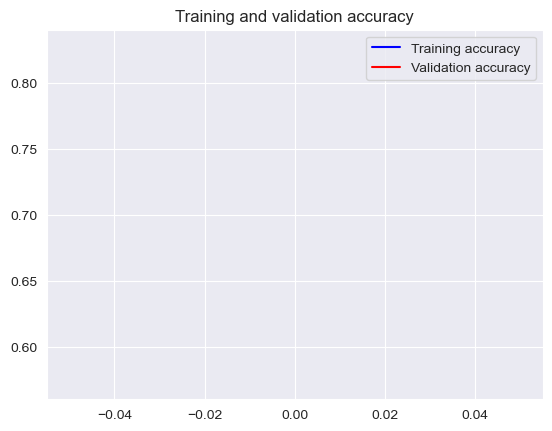

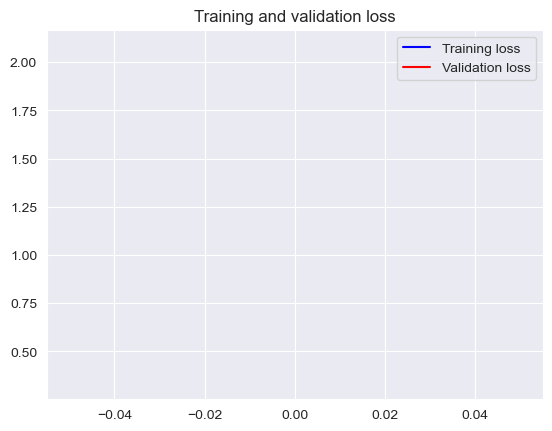

In [212]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

# 🔮Making predictions on the Test Data

In [213]:
labels = train_images.class_indices
labels_dic = dict((v,k) for k,v in labels.items())


{0: 'ABBOTTS BABBLER', 1: 'ABBOTTS BOOBY'}

In [214]:
def create_lables_dic(train_ImageDataGenerator):
    # Map the label
    labels = (train_ImageDataGenerator.class_indices)
    labels_dic = dict((v,k) for k,v in labels.items())
    return labels_dic
    


def apply_model(model,labels_dic,test_ImageDataGenerator,test_df):
# apply the model    
    pred = model.predict(test_ImageDataGenerator)
    pred = np.argmax(pred,axis=1)
    pred = [labels_dic[k] for k in pred]

    test_df['predict_label'] = pred
    test_df['status'] = test_df['predict_label']==test_df['label']
    return test_df     

In [215]:
labels_dic = create_lables_dic(train_images)
test_df = apply_model(model,labels_dic,test_images,test_df)

3/3 [==============================] - 3s 402ms/step


In [ ]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# 📊Plotting the Classification Reports and Confusion Matrix

<div style="background-color:#fff1cc; padding: 20px;">
<p style="font-size:20px; font-family:verdana; line-height: 1.7em"><b>Confusion matrix</b> and <b>classification report</b> are two important tools used for evaluating the performance of an image classification model.</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">A <b>confusion matrix</b> is a table that summarizes the number of correct and incorrect predictions made by a classification model on a set of test data. It is usually represented as a square matrix with rows and columns representing the predicted and true class labels, respectively. The entries of the matrix indicate the number of test samples that belong to a certain class, and how many of those were classified correctly or incorrectly by the model. A confusion matrix can provide a detailed breakdown of the performance of the model, including measures such as accuracy, precision, recall, and F1-score for each class. It can be used to identify specific areas where the model is making errors, and to diagnose problems with the model's predictions.</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">A <b>classification report</b> is a summary of the key performance metrics for a classification model, including precision, recall, and F1-score, as well as the overall accuracy of the model. It provides a concise overview of the model's performance, typically broken down by class, and can be used to quickly assess the strengths and weaknesses of the model. The report is often presented as a table, with each row representing a class and columns showing various performance metrics. The report may also include other metrics such as support (the number of test samples belonging to a particular class), and the macro- and micro-averages of the performance metrics across all classes.</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">In image classification, both confusion matrix and classification report are important tools for evaluating the performance of the model, identifying areas for improvement, and making decisions about how to adjust the model's architecture or training parameters.</p>
</div>

In [ ]:
y_test = list(test_df.label)
print(classification_report(y_test, pred))

In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

# ☀️Grad-Cam Visualization

<div style="background-color:#fff1cc; padding: 20px;">
<p style="font-size:20px; font-family:verdana; line-height: 1.7em"><b>Grad-CAM (Gradient-weighted Class Activation Mapping)</b> is a technique used to visualize the regions of an input image that were most relevant for a neural network's prediction. It allows you to see which regions of the image the model focused on while making its prediction. Grad-CAM is a modification of the CAM technique that extends the latter to any model that uses a convolutional neural network (CNN) as its underlying architecture.</p>
</div>

In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))

    return cam_path


preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

In [ ]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()

***

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
        <p style="padding: 10px;
              color:white;">
            Thanks for viewing my work. If you like it, consider sharing it to others or give feedback to improve the notebook. Have a beautiful day my friend.
        </p>
    </div>

<center><img src='https://media4.giphy.com/media/M9gbBd9nbDrOTu1Mqx/giphy.gif?cid=790b7611704aa2ca4e403287801480a6c753abf45f3e6242&rid=giphy.gif&ct=s'
     height=30px width=160px /></center>